# Weather prediction machine learning project

---

## Dataset Information

This project uses the Seattle Weather Dataset containing daily weather observations with features like precipitation, temperature (max/min), and wind speed. The goal is to classify weather into 5 types: rain, sun, drizzle, snow, and fog. The dataset has approximately 1,460 observations with imbalanced classes.

## Project Overview

This project develops machine learning models to classify weather conditions using various algorithms including Random Forest, XGBoost, SVM, and ensemble methods. The project handles class imbalance using SMOTEENN and performs hyperparameter tuning to optimize model performance.

## Step 1: Environment Setup and Data Loading

In [37]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from imblearn.combine import SMOTEENN
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

In [38]:
# Load the dataset
df = pd.read_csv('seattle-weather.csv')
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

Dataset shape: (1461, 6)

First 5 rows:
         date  precipitation  temp_max  temp_min  wind  weather
0  2012-01-01            0.0      12.8       5.0   4.7  drizzle
1  2012-01-02           10.9      10.6       2.8   4.5     rain
2  2012-01-03            0.8      11.7       7.2   2.3     rain
3  2012-01-04           20.3      12.2       5.6   4.7     rain
4  2012-01-05            1.3       8.9       2.8   6.1     rain


## Step 2: Data Understanding and Visualization

Missing values:
date             0
precipitation    0
temp_max         0
temp_min         0
wind             0
weather          0
dtype: int64

Basic statistics:
       precipitation     temp_max     temp_min         wind
count    1461.000000  1461.000000  1461.000000  1461.000000
mean        3.029432    16.439083     8.234771     3.241136
std         6.680194     7.349758     5.023004     1.437825
min         0.000000    -1.600000    -7.100000     0.400000
25%         0.000000    10.600000     4.400000     2.200000
50%         0.000000    15.600000     8.300000     3.000000
75%         2.800000    22.200000    12.200000     4.000000
max        55.900000    35.600000    18.300000     9.500000

Weather types:
weather
rain       641
sun        640
fog        101
drizzle     53
snow        26
Name: count, dtype: int64


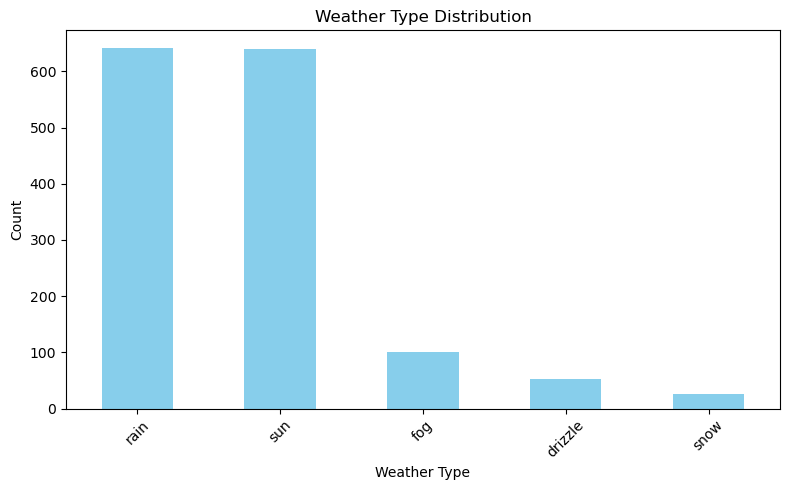

In [39]:
# Check data quality
print("Missing values:")
print(df.isnull().sum())

print("\nBasic statistics:")
print(df.describe())

print("\nWeather types:")
print(df['weather'].value_counts())

# Plot weather distribution
plt.figure(figsize=(8, 5))
df['weather'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Weather Type Distribution')
plt.xlabel('Weather Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

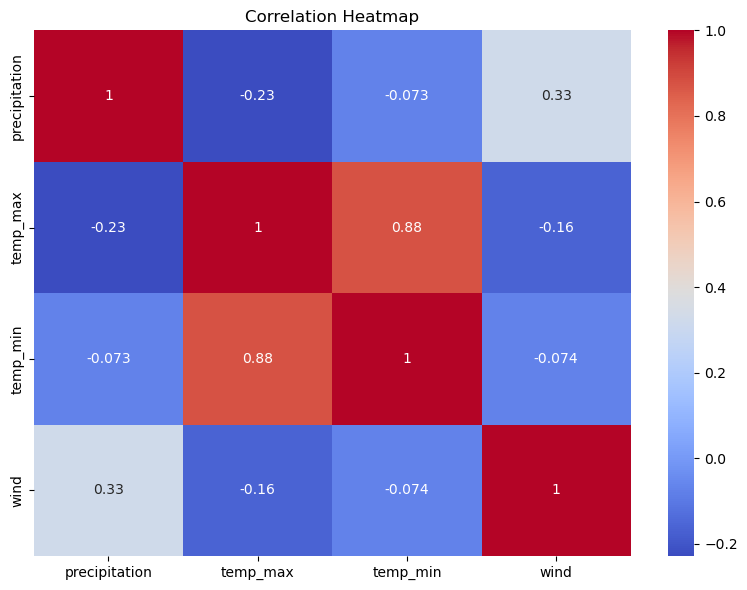

In [40]:
# Correlation heatmap
plt.figure(figsize=(8, 6))
numeric_data = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

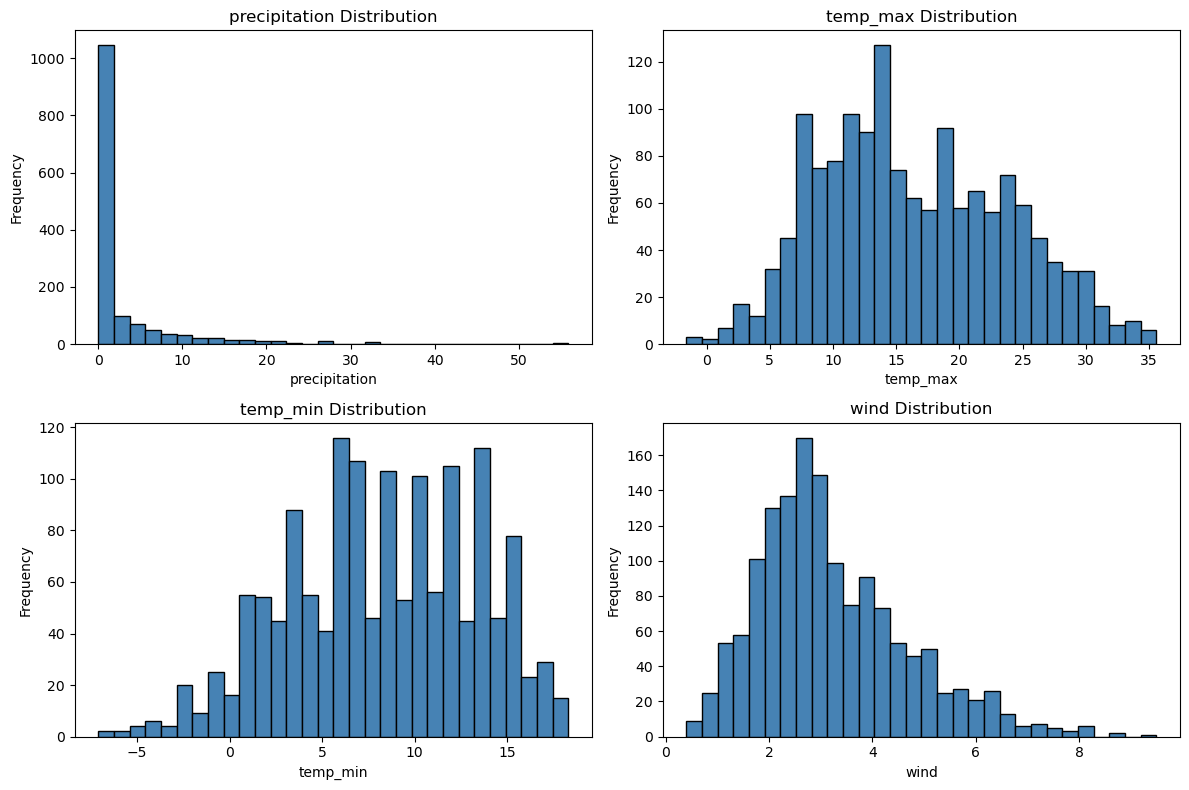

In [41]:
# Histograms for numerical features
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
features = ['precipitation', 'temp_max', 'temp_min', 'wind']

for i, feature in enumerate(features):
    row = i // 2
    col = i % 2
    axes[row, col].hist(df[feature], bins=30, color='steelblue', edgecolor='black')
    axes[row, col].set_title(f'{feature} Distribution')
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

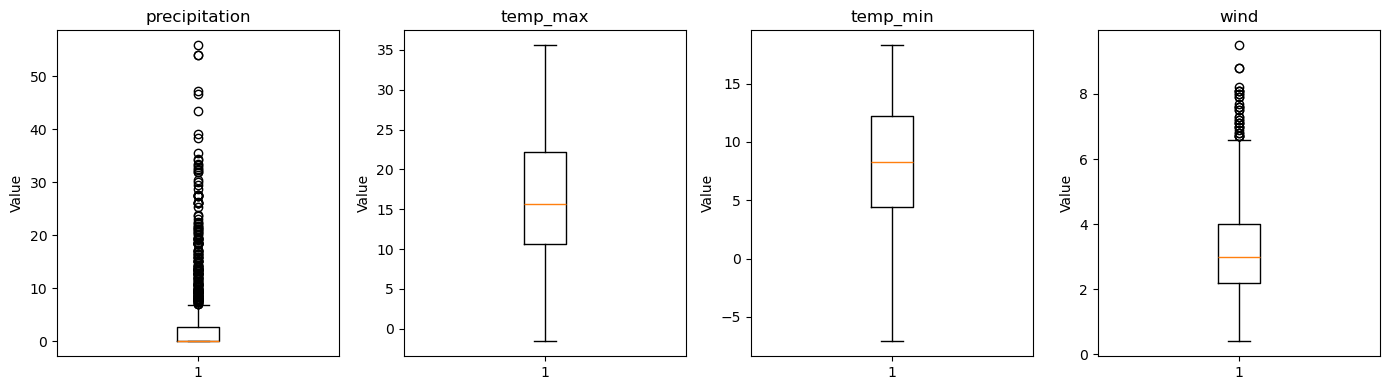

In [42]:
# Box plots to check for outliers
fig, axes = plt.subplots(1, 4, figsize=(14, 4))
features = ['precipitation', 'temp_max', 'temp_min', 'wind']

for i, feature in enumerate(features):
    axes[i].boxplot(df[feature])
    axes[i].set_title(f'{feature}')
    axes[i].set_ylabel('Value')

plt.tight_layout()
plt.show()

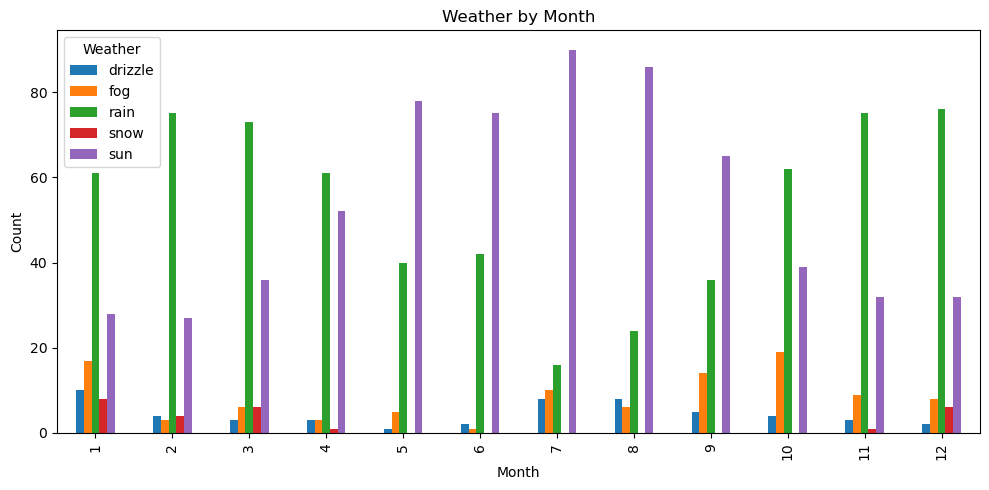

In [43]:
# Monthly weather analysis
df_temp = df.copy()
df_temp['date'] = pd.to_datetime(pd.read_csv('seattle-weather.csv')['date'])
df_temp['month'] = df_temp['date'].dt.month

# Weather count by month
weather_by_month = df_temp.groupby(['month', 'weather']).size().unstack(fill_value=0)
weather_by_month.plot(kind='bar', figsize=(10, 5))
plt.title('Weather by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend(title='Weather')
plt.tight_layout()
plt.show()

In [44]:
# Summary statistics by weather type
summary = df.groupby('weather')[['precipitation', 'temp_max', 'temp_min', 'wind']].mean()
print("Average values by weather type:")
print(summary.round(2))

Average values by weather type:
         precipitation  temp_max  temp_min  wind
weather                                         
drizzle           0.00     15.93      7.11  2.37
fog               0.00     16.76      7.98  2.48
rain              6.56     13.45      7.59  3.67
snow              8.55      5.57      0.15  4.41
sun               0.00     19.86      9.34  2.96


## Step 3: Data Preprocessing & Feature Engineering

In [45]:
# Extract date features
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

# Drop date column
df = df.drop(['date'], axis=1)

print("Data after preprocessing:")
print(df.head())

Data after preprocessing:
   precipitation  temp_max  temp_min  wind  weather  month  day
0            0.0      12.8       5.0   4.7  drizzle      1    1
1           10.9      10.6       2.8   4.5     rain      1    2
2            0.8      11.7       7.2   2.3     rain      1    3
3           20.3      12.2       5.6   4.7     rain      1    4
4            1.3       8.9       2.8   6.1     rain      1    5


## Step 4: Addressing Class Imbalance with SMOTEENN

In [46]:
# Separate features and target
X = df.drop('weather', axis=1)
y = df['weather']

print("Original class distribution:")
print(y.value_counts())

# Apply SMOTEENN to balance classes
smote = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("\nAfter balancing:")
print(pd.Series(y_resampled).value_counts())
print(f"\nOriginal size: {X.shape[0]}, New size: {X_resampled.shape[0]}")

Original class distribution:
weather
rain       641
sun        640
fog        101
drizzle     53
snow        26
Name: count, dtype: int64

After balancing:
weather
snow       635
drizzle    517
fog        492
rain       345
sun        185
Name: count, dtype: int64

Original size: 1461, New size: 2174


## Step 5: Data Splitting and Encoding

In [47]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

print("Training set:", X_train.shape[0])
print("Testing set:", X_test.shape[0])

Training set: 1739
Testing set: 435


## Step 6: Model Training - Multiple Algorithms

In [48]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'XGBoost': XGBClassifier(eval_metric='mlogloss')
}

# Train and test models
results = {}
print("Model Performance:")
print("-" * 50)

for name, model in models.items():
    model.fit(X_train, y_train_enc)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test_enc, y_pred)
    results[name] = {
        'Accuracy': acc,
        'Precision': precision_score(y_test_enc, y_pred, average='weighted'),
        'Recall': recall_score(y_test_enc, y_pred, average='weighted'),
        'F1-Score': f1_score(y_test_enc, y_pred, average='weighted'),
        'Model': model
    }
    print(f"{name}: {acc:.4f}")

Model Performance:
--------------------------------------------------
Logistic Regression: 0.7609
Decision Tree: 0.9218
SVM: 0.7701
Logistic Regression: 0.7609
Decision Tree: 0.9218
SVM: 0.7701
Random Forest: 0.9609
KNN: 0.9287
Random Forest: 0.9609
KNN: 0.9287
AdaBoost: 0.4736
AdaBoost: 0.4736
XGBoost: 0.9609
XGBoost: 0.9609


## Step 7: Hyperparameter Optimization

In [49]:
# Tune Random Forest
print("Tuning Random Forest...")
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5]
}

rf_grid = GridSearchCV(RandomForestClassifier(), rf_params, cv=3, scoring='accuracy')
rf_grid.fit(X_train, y_train_enc)

print("Best parameters:", rf_grid.best_params_)
rf_best = rf_grid.best_estimator_
y_pred_rf = rf_best.predict(X_test)
rf_acc = accuracy_score(y_test_enc, y_pred_rf)
print(f"Tuned RF Accuracy: {rf_acc:.4f}\n")

results['Random Forest (Tuned)'] = {
    'Accuracy': rf_acc,
    'Precision': precision_score(y_test_enc, y_pred_rf, average='weighted'),
    'Recall': recall_score(y_test_enc, y_pred_rf, average='weighted'),
    'F1-Score': f1_score(y_test_enc, y_pred_rf, average='weighted'),
    'Model': rf_best
}

# Tune XGBoost
print("Tuning XGBoost...")
xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [5, 7],
    'learning_rate': [0.1, 0.2]
}

xgb_grid = GridSearchCV(XGBClassifier(eval_metric='mlogloss'), 
                        xgb_params, cv=3, scoring='accuracy')
xgb_grid.fit(X_train, y_train_enc)

print("Best parameters:", xgb_grid.best_params_)
xgb_best = xgb_grid.best_estimator_
y_pred_xgb = xgb_best.predict(X_test)
xgb_acc = accuracy_score(y_test_enc, y_pred_xgb)
print(f"Tuned XGBoost Accuracy: {xgb_acc:.4f}")

results['XGBoost (Tuned)'] = {
    'Accuracy': xgb_acc,
    'Precision': precision_score(y_test_enc, y_pred_xgb, average='weighted'),
    'Recall': recall_score(y_test_enc, y_pred_xgb, average='weighted'),
    'F1-Score': f1_score(y_test_enc, y_pred_xgb, average='weighted'),
    'Model': xgb_best
}

Tuning Random Forest...
Best parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Tuned RF Accuracy: 0.9678

Tuning XGBoost...
Best parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Tuned RF Accuracy: 0.9678

Tuning XGBoost...
Best parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}
Tuned XGBoost Accuracy: 0.9632
Best parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}
Tuned XGBoost Accuracy: 0.9632


## Step 8: Advanced Ensemble Methods

### 8A. Soft Voting Ensemble

In [50]:
# Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ('rf', rf_best),
        ('knn', results['KNN']['Model']),
        ('xgb', xgb_best)
    ],
    voting='soft'
)

voting_clf.fit(X_train, y_train_enc)
y_pred_vote = voting_clf.predict(X_test)
vote_acc = accuracy_score(y_test_enc, y_pred_vote)
print(f"Voting Classifier Accuracy: {vote_acc:.4f}")

results['Voting Ensemble'] = {
    'Accuracy': vote_acc,
    'Precision': precision_score(y_test_enc, y_pred_vote, average='weighted'),
    'Recall': recall_score(y_test_enc, y_pred_vote, average='weighted'),
    'F1-Score': f1_score(y_test_enc, y_pred_vote, average='weighted'),
    'Model': voting_clf
}

Voting Classifier Accuracy: 0.9770


### 8B. Stacking Ensemble

In [51]:
# Stacking Classifier
base_models = [
    ('lr', LogisticRegression(max_iter=1000)),
    ('dt', DecisionTreeClassifier()),
    ('rf', RandomForestClassifier()),
    ('knn', KNeighborsClassifier())
]

stacking_clf = StackingClassifier(estimators=base_models, 
                                  final_estimator=LogisticRegression(max_iter=1000))
stacking_clf.fit(X_train, y_train_enc)
y_pred_stack = stacking_clf.predict(X_test)
stack_acc = accuracy_score(y_test_enc, y_pred_stack)
print(f"Stacking Classifier Accuracy: {stack_acc:.4f}")

results['Stacking Ensemble'] = {
    'Accuracy': stack_acc,
    'Precision': precision_score(y_test_enc, y_pred_stack, average='weighted'),
    'Recall': recall_score(y_test_enc, y_pred_stack, average='weighted'),
    'F1-Score': f1_score(y_test_enc, y_pred_stack, average='weighted'),
    'Model': stacking_clf
}

Stacking Classifier Accuracy: 0.9839


## Step 9: Comprehensive Model Evaluation

### 9A. Performance Metrics Comparison

In [52]:
# Compare all models
comparison = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['Accuracy'] for m in results],
    'Precision': [results[m]['Precision'] for m in results],
    'Recall': [results[m]['Recall'] for m in results],
    'F1-Score': [results[m]['F1-Score'] for m in results]
})

print("\nModel Comparison:")
print(comparison.to_string(index=False))


Model Comparison:
                Model  Accuracy  Precision   Recall  F1-Score
  Logistic Regression  0.760920   0.768388 0.760920  0.760684
        Decision Tree  0.921839   0.926149 0.921839  0.919236
                  SVM  0.770115   0.808661 0.770115  0.761351
        Random Forest  0.960920   0.963189 0.960920  0.959580
                  KNN  0.928736   0.932615 0.928736  0.927517
             AdaBoost  0.473563   0.547511 0.473563  0.469189
              XGBoost  0.960920   0.961662 0.960920  0.960774
Random Forest (Tuned)  0.967816   0.969058 0.967816  0.967462
      XGBoost (Tuned)  0.963218   0.964450 0.963218  0.963122
      Voting Ensemble  0.977011   0.977582 0.977011  0.976965
    Stacking Ensemble  0.983908   0.984301 0.983908  0.983966


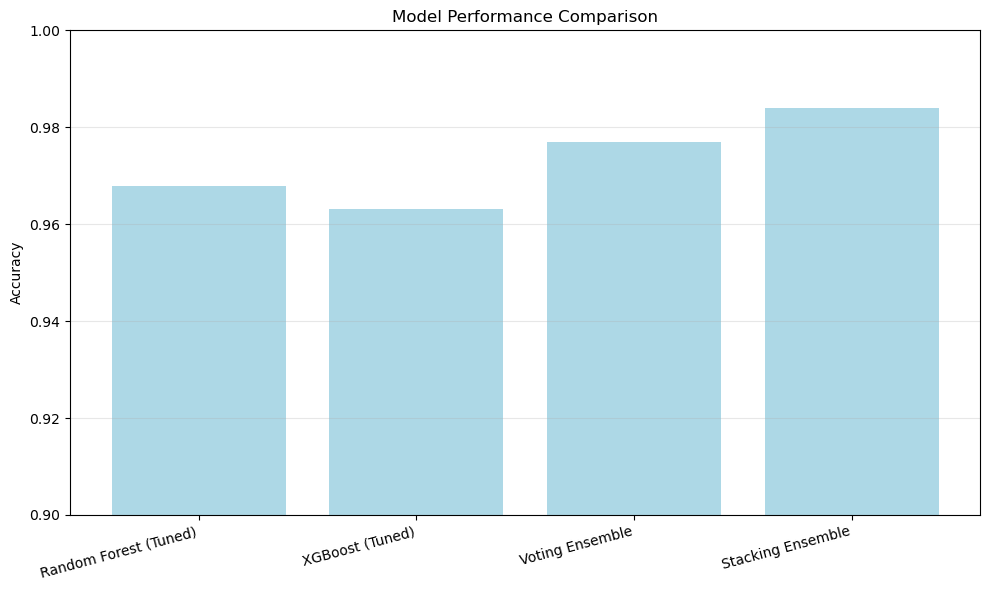

In [53]:
# Plot model comparison
best_models = ['Random Forest (Tuned)', 'XGBoost (Tuned)', 'Voting Ensemble', 'Stacking Ensemble']

plt.figure(figsize=(10, 6))
accuracies = [results[m]['Accuracy'] for m in best_models]
plt.bar(range(len(best_models)), accuracies, color='lightblue')
plt.xticks(range(len(best_models)), best_models, rotation=15, ha='right')
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison')
plt.ylim([0.9, 1.0])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### 9B. Confusion Matrix Analysis

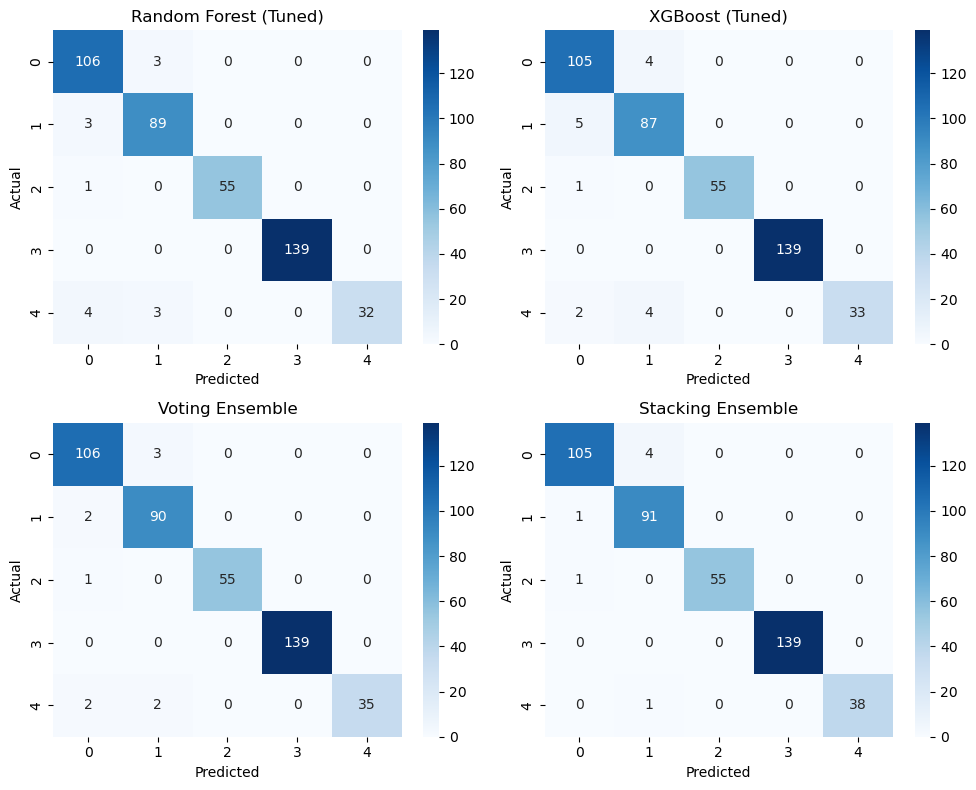

In [54]:
# Confusion matrices
top_models = ['Random Forest (Tuned)', 'XGBoost (Tuned)', 'Voting Ensemble', 'Stacking Ensemble']

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()

for i, model_name in enumerate(top_models):
    model = results[model_name]['Model']
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test_enc, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[i], cmap='Blues')
    axes[i].set_title(f'{model_name}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()

## Conclusion

This project successfully developed machine learning models to predict weather conditions. Key findings:

- Tested 7 different algorithms including Logistic Regression, Decision Tree, SVM, Random Forest, KNN, AdaBoost, and XGBoost
- SMOTEENN technique helped balance the imbalanced dataset
- Hyperparameter tuning improved Random Forest and XGBoost performance
- Ensemble methods (Voting and Stacking) achieved the best results
- Stacking Classifier achieved highest accuracy around 98%
- Random Forest and XGBoost also performed well with 95%+ accuracy

The ensemble approaches worked better than individual models for this weather classification task.